<a href="https://colab.research.google.com/github/kmjohnson3/ML4MI_Bootcamp_Development/blob/master/MRI_Modality_Detection_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This tutorial will give an example application of using deep learning for categorization of images. This example will demonstrate how to implement a convolutional neural network for the identifying the type of MRI contrast or pulse sequence from a given input. The tutorial will have 3 main parts:

1. Loading and organization of data for model training
2. Creating a multi-class categorization deep learning model
3. Training with pre-defined networks

Keep an eye out for questions through this demo to test your new DL knowledge and critical thinking. There are answers at the end of the document.

### Initial Preparation
These are some modules that we will need throughout this example:

In [0]:
import os
import numpy

import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# initialize random seeds for reproducible results
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

We will import other necessary modules as we go and need them.

Next, we need to copy the files to a place where our CoLab notebook can read them.

In [24]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy and unarchive data
!echo "Copying Data Locally (Image Modality) -- Please be patient, this may take a while"
!tar xf /content/drive/'My Drive'/ML4MI_BOOTCAMP_DATA/ImageModalityDetector.tar --directory /home/
!echo "Complete!"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying Data Locally (Image Modality)


# Part 1: Data Organization
Data for this example has already been prepared for you. The data utilized here is from the 2017 MICCAI Multimodal Brain Tumor Segmentation (BRATS) Challenge. The data consists of magnetic resonance imaging (MRI) data from 19 different institutions in subjects with glioblastoma/high grade glioma (GBM/HGG) and low grade glioma (LGG). The different MRI scans include: T1-weighted (t1), post-contrast Gadolinium-enhanced images (t1ce), T2-weighted (t2), and T2 fluid attenuated inversion recovery (flair). More information on the 2017 BRATS Challenge is available here: https://www.med.upenn.edu/sbia/brats2017/data.html

Data preparation for this example is similar to the approach that utilized in the previous example. This includes the use of a Keras image data generator. Your instructor has converted the BRATS data from the NiFTI imaging format (https://nifti.nimh.nih.gov/nifti-1/) to portable network graphics (.png) files, which is an image file format that can be read natively in Keras. Each .png file is a 256x256 axial image. In a later exercise, you will load image data directly from DICOM files as a further example. The structure of the data folder is as follows:
<pre>
  --brats_contrast_detector
     --test (17,100 files)
           --flair
           --t1
           --t1ce
           --t2
     --train (39,900 files)
           --flair
           --t1
           --t1ce
           --t2
     --validate (17,100 files)
           --flair
           --t1
           --t1ce
           --t2
</pre>

Configuring the images in this particular folder structure allows easy use of a Keras ImageDataGenerator to perform the categorization of the different types of data for which we wish to discriminate. Specifically for this example, this includes the type of MRI scan: (flair, t1, t1ce, or t2) of each input image. The BRATS Dataset includes images from 285 subjects, and in this structure the data has been divided into ~66 subjects in the testing set (test), ~153 subjects in the training set (train), and ~66 subjects in the validation set (validate). Thus, each subject contributes 65 slices for each type of MRI scan.

Now let's work on setting up the ImageDataGenerator to read in our data. Keras has built-in capabilities to perform basic types of data augmentation. That is the ability to apply different, randomized transformations to the input data to increase the diversity of the dataset. In this exercise we will explore the use of an ImageDataGenerator to perform varying types of augmentation. Let's try it out:

In [0]:
# first let's use some varaibles to record information about our data
dims = 256 # this is the size of out input data, 256x256
#classes = ? # how many types of MRI scans do we have?
#<SOLUTION>
classes = 4
#</SOLUTION>
batch_size = 15 # this is how many input images will be utilized for each training step

# this is the folder that contains the 39,900 images that will be used for training
train_folder = '/home/ImageModalityDetector/train'
# this is the folder htat contains the 17,100 images that will be used for validation
valid_folder = '/home/ImageModalityDetector/validate'

# set up the ImageDataGenerator for the validation data first. We will not perform augmentation on the validation data, but we do need to normalize the input intensity of the input images:
valid_datagen = ImageDataGenerator(rescale=1./255)

# now set up the ImageDataGenerator for the training:
# Go to the documentation page for the ImageDataGenerator (https://keras.io/preprocessing/image/#imagedatagenerator-class)
#  and learn how to add in a rotation, a shear, width shift, height shift, and zoom augmentation.
#  What are reasonable values for this type of dataset?
#train_datagen = ?
#<SOLUTION>
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=10,shear_range=1,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2)
#</SOLUTION>

# Model Configuration
In this example we will explore the use of different model structures that are already available in Keras. But first let's start with the model that used in the last example. Can you modify the existing model structure? How will it work with the number of classes in this new dataset?

In [0]:
# insert the model you used in the last example here
#<SOLUTION>
img_input = layers.Input(shape=(dims,dims,1))
x = layers.Conv2D(15, (3, 3), strides=(4,4), padding='same', kernel_initializer='he_normal')(img_input)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2), strides=None)(x)
x = layers.Flatten()(x)     #reshape to 1xN
x = layers.Dense(20, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dense(classes, activation='relu')(x)
model = Model(inputs=img_input, outputs=x)
#</SOLUTION>

# now lets compile the model.
#  What loss function should be used? binary_crossentropy does not make sense anymore.
#    Here is a list of available loss functions in Keras: https://keras.io/losses/
#  What metrics should be used? accuracy is also not appropriate here.
#    Here is a list of available metrics in Keras: https://keras.io/metrics/
#model.compile(loss="?", optimizer=optimizers.Adam(lr=1e-3), metrics=["?"])
#<SOLUTION>
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=1e-5), metrics=["categorical_accuracy"])
#</SOLUTION>

# Model Training
Let's work on training this this model and dataset.

First, let's set up the ImageDataGenerator to use the flow_from_directory function. This is very useful because it allows us to train large datasets that we might not be able to entirely load into our computer's memory. Also, it provides the facilities for on-the-fly augmentation that we are now using. 

In [35]:
# the call to flow_from_directory, technically it returns a DirectoryIterator object
#  that we pass to the model.fit_generator. Let's set it up:
# What should class_mode be set to here?
#train_generator = train_datagen.flow_from_directory(train_folder, batch_size=batch_size, target_size=(dims,dims), shuffle=True, class_mode='?', color_mode='grayscale')
#valid_generator = valid_datagen.flow_from_directory(valid_folder, batch_size=batch_size, target_size=(dims,dims), shuffle=True, class_mode='?', color_mode='grayscale')
#<SOLUTION>
train_generator = train_datagen.flow_from_directory(train_folder, batch_size=batch_size, target_size=(dims,dims), shuffle=True, class_mode='categorical', color_mode='grayscale')
valid_generator = valid_datagen.flow_from_directory(valid_folder, batch_size=batch_size, target_size=(dims,dims), shuffle=True, class_mode='categorical', color_mode='grayscale')
#</SOLUTION>

Found 39900 images belonging to 4 classes.
Found 17100 images belonging to 4 classes.


Now we are ready to start training. Let's get this get this going:

In [36]:
# steps is the number of batches that are passed during each epoch
#   IRL, this should be large enough such that we pass through the entire
#        dataset (or equivalent) for each epoch. That is: 9975/batch_size
#   For practicality for this course, let's make it smaller so we can progress
#    through this exercise at a quicker pace.
steps = 500
# val_steps is the number of batches that are passed during each validation epoch
#   IRL, this should be large enough such that we pass through the entire
#        dataset (or equivalent) for each epoch. That is: 4275/batch_size
#   For practicality for this course, let's make it smaller so we can progress
#    through this exercise at a quicker pace.
val_steps = 100

# now let's train for 5 epochs (note that this is unrealistic demonstration of model training)
history = model.fit_generator(train_generator, steps_per_epoch=steps, epochs=5, 
                              validation_data=valid_generator, validation_steps=val_steps)

# It should take approximately 5 minutes to train. Maybe you should take a break

W0819 21:58:57.217215 140367386662784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
500/500 [==============================] - 56s 113ms/step - loss: 4.1248 - categorical_accuracy: 0.2556 - val_loss: 1.4838 - val_categorical_accuracy: 0.2453
Epoch 2/5
390/500 [======================>.......] - ETA: 11s - loss: 1.4618 - categorical_accuracy: 0.2516

KeyboardInterrupt: ignored

Now that training is complete. Let's plot the losses:

NameError: ignored

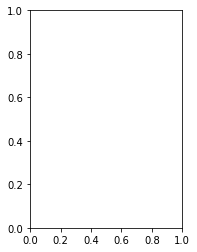

In [37]:
# first, we need to import matplotlib to enable plotting
#%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure(figsize=(6.0, 4.0));
# Plot the losses
plt.subplot(121)
plt.plot(history.epoch,history.history['loss'],'b-s')
plt.plot(history.epoch,history.history['val_loss'],'r-s')
plt.legend(['Training Data',
            'Validation Data'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Loss Plot')
# Plot the accuracy
plt.subplot(122)
plt.plot(history.epoch,history.history['categorical_accuracy'],'b-s')
plt.plot(history.epoch,history.history['val_categorical_accuracy'],'r-s')
plt.legend(['Training Data',
            'Validation Data'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.show()

**Question 1:** Given the number of input classes that we have. What would be the accuracy of a model that was as good as a random guess? What was the accuracy of your model?

### Improved Network Structures
I hope you agree that we can do better. Let's try this again but with different model. Keras has the functionality to use pre-existing network structures. Let's explore that functionality. Please take a look at the Keras Applications page (https://keras.io/applications/), which describes pre-configured networks that are available.

We will try MobileNet, which is designed to be an efficient network. Here is more information about the MobileNet structure: https://arxiv.org/pdf/1704.04861.pdf

In [45]:
# first we need to import MobileNet
from keras.applications.mobilenet import MobileNet

# here instantiate a MobileNet that is specific to our data (image size and number of classes) with randomized initial weights
#model_mn = ?
#<SOLUTION>
model_mn = MobileNet(weights=None, input_shape=(dims,dims,1), classes=classes)
#</SOLUTION>

# now let's train it
model_mn.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=1e-5), metrics=["categorical_accuracy"])
history_mn = model.fit_generator(train_generator, steps_per_epoch=steps, epochs=5,
                              validation_data=valid_generator, validation_steps=val_steps)

Epoch 1/5
 27/500 [>.............................] - ETA: 48s - loss: 1.4158 - categorical_accuracy: 0.2889

KeyboardInterrupt: ignored

Now we can plot the losses compared to our first network:

In [0]:
plt.figure(figsize=(6.0, 4.0));
plt.subplot(121)
plt.plot(history_mn.epoch,history_mn.history['loss'],'b-s')
plt.plot(history.epoch,history.history['loss'],'g-s')
plt.legend(['MobileNet Training Data',
            '1st Network Training Data'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.subplot(122)
plt.plot(history_mn.epoch,history_mn.history['val_categorical_accuracy'],'r-s')
plt.plot(history.epoch,history.history['val_categorical_accuracy'],'c-s')
plt.legend(['MobileNet Validation Data',
            '1st Network Validation Data'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.show()

This looks like it is doing much better. Unfortunately we do not have the time today to complete the full training. Fortunately, your instructor has trained this network (and several others) for up to 30 epochs. Let's work on next loading these trained models and compare their performance. Note that we are using a Keras callback function, ModelCheckpoint (https://keras.io/callbacks/#modelcheckpoint), to save the best weights of the trained network. We will load these weight files in the next step. 

For your information, the code that was used to train the different networks is below:

#### To define VGG16 - https://arxiv.org/abs/1409.1556
<pre>
from keras.applications.vgg16 import VGG16
model = VGG16(weights=None, input_shape=(dims,dims,1), classes=classes)
</pre>
#### To define InceptionV3 - http://arxiv.org/abs/1512.00567
<pre>
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(weights=None, input_shape=(dims,dims,1), classes=classes)
</pre>
#### To define DenseNet - https://arxiv.org/abs/1608.06993
<pre>
from keras.applications.densenet import DenseNet121
model = DenseNet121(weights=None, input_shape=(dims,dims,1), classes=classes)
</pre>
#### Used to train all of the above models
<pre>
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=1e-4), metrics=["categorical_accuracy"])
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('weights.h5', monitor='loss', save_best_only=True)
history = model.fit_generator(train_generator, steps_per_epoch=steps, epochs=30, callbacks=[model_checkpoint],
                              validation_data=valid_generator, validation_steps=val_steps )
</pre>



### Comparing Different Models
Let's start by loading up the different history files that were saved for each model, and let's take a look at the loss plot for each epoch.

In [0]:
# load in history files
history_inceptionv3 = numpy.load('history_inceptionv3.npy')
history_mobilenet = numpy.load('history_mobilenet.npy')
history_vgg16 = numpy.load('history_vgg16.npy')

# let's plot them
plt.figure(figsize=(6.0, 4.0));
plt.subplot(121)
plt.plot(history_inceptionv3.all()['loss'],'b-s')
plt.plot(history_mobilenet.all()['loss'],'r-s')
plt.plot(history_vgg16.all()['loss'],'g-s')
plt.legend(['InceptionV3',
            'MobileNet',
            'VGG16'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylabel('Loss Plot')

plt.subplot(122)
plt.plot(history_inceptionv3.all()['categorical_accuracy'],'b-s')
plt.plot(history_mobilenet.all()['categorical_accuracy'],'r-s')
plt.plot(history_vgg16.all()['categorical_accuracy'],'g-s')
plt.legend(['InceptionV3',
            'MobileNet',
            'VGG16'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.show()

**Question 2:** Which network performs the best? Do you think training is complete after 30 epochs?

Now let's evaluate some data and see what happens. Let's using the InceptionV3 model and load the existing trained weights:

In [0]:
from keras.applications.inception_v3 import InceptionV3
model_i = InceptionV3(weights='weights_inceptionv3.h5', input_shape=(dims,dims,1), classes=classes)
model_i.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=1e-4), metrics=["categorical_accuracy"])

Now let's work on testing the model with some data

In [0]:
# let's set up an ImageDataGenerator for the test data
test_folder = os.path.join(os.getcwd(),'test')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(valid_folder, batch_size=1, target_size=(dims,dims), class_mode='categorical', color_mode='grayscale')

In [0]:
# get the next image from the generator
X,Y = test_generator.next()

# visualize the current image
plt.figure(figsize=(6.0, 4.0))
plt.imshow(X[0,:,:,0],cmap='gray')

plt.show()

# now predict
y = model_i.predict(X)

# display the prediction as a printed text message
actual_type = [key for key in test_generator.class_indices.items() if key[1] == numpy.argmax(Y)][0][0]
predicted_type = [key for key in test_generator.class_indices.items() if key[1] == numpy.argmax(y)][0][0]
print('The actual type was {}, the predicted type was {}'.format(actual_type,predicted_type))

You can re-run the cell above to get the next iteration from the test data generator. Keep running it until you identify several misclassifications of the MRI pulse sequence type.

**Question 3:** When the network failed to identify the pulse sequence type, what characteristics did you notice in the images? For example, what regions of the brain did the algorithm seem to struggle with identifying? Do you think that you could have done better?

### End of Exercise
This is the end of this exercise. If you have extra time and would like to try a few advanced ideas, please consider trying the following:
1. Modify the code above to include predictions for MobileNet and VGG16. Perform the analysis on the 3 different networks for each slice. Are failure cases similar between networks?
2. Try re-training the MobileNet network without augmentation. Do you notice any differences?
3. Try adding different types of augmentation, such as left-right and up-down flips. What about adding more extreme degrees of augmentation? Does this improve network performance?
4. Try adding augmentation to the evaluation stage to see how the network performs with augmentation.
5. Explore the other types of available Callback functions during model fitting. There are many useful predefined types of callbacks that you can use to get more information from your network during training. Read more about them here: https://keras.io/callbacks/